In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

from myPackage import cmdInput
%matplotlib widget

In [2]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.5


numSheets = 10

maxh_edges = d/numSheets*1/2 * 0.5


from meshGen import mesh2DLaminates

onlySmooth = True


## Reference Solution

In [4]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, onlySmooth=onlySmooth, maxh_edges=maxh_edges)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

Boundaries {'top', 'iright', 'right', 'bottom', 'left', 'ileft'}
Materials {'outer', 'inner', 'insulation'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|gap"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 3.3002441086959995     
CG iteration 2, residual = 2.616190806437063e-12     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})


energy:	7.053763277883365e-26


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

## Multiscale

In [7]:
modelHalfAir=True



cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", onlySmooth=onlySmooth,  maxh_edges=maxh_edges)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)


('outer', 'outer', 'multiscale')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

In [8]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 0


def calcMultiscale(useGradients=True, drawPhis=True):

    # microshape functions
    orderPhi = [
            cl_Phi(1, fes_order=order0, material="multiscale", dirichlet="", useGradients=useGradients), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="iright_outer|ileft_outer|iright|ileft", inAir=False, modelHalfAir=False), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="iright_outer|ileft_outer|iright|ileft", inIron=False, modelHalfAir=False), 
        ]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi)

    VSpace = []
    # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="right|left")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=True) * dx("multiscale|smoothFrame")


    # h = specialcf.mesh_size
    # um = sum([cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1] for i in range(len(cl_gradgradMS.u))])
    # vm = sum([cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1] for i in range(len(cl_gradgradMS.v))])
    # if True:
    #     # a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft|iright", skeleton=True)
    #     a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft_outer|iright_outer")
    


    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale|smoothFrame"))
    
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp,    energy_MS, cl_gradgradMS = calcMultiscale(False, drawPhis=False)
print(energy_MS)
print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


CG iteration 1, residual = 2.8182032169118325     
CG iteration 2, residual = 1.0210867859283268e-12     
0.8891848890532127
0.00022336884418807295


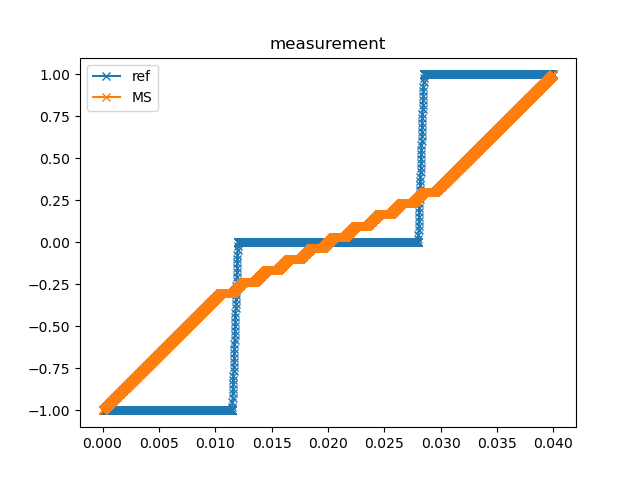

In [9]:
from myPackage import evalOnLine
import matplotlib.pyplot as plt
start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02



start = -D/2
end = D/2

evalOnLine(sol_ref , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="x", show=False, label="ref", N = 3000);
tmp, _, _ = evalOnLine(sum(sol_comp_MS) , meshRef, [start, 0, 0], [end, 0, 0], plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=3000);

plt.legend()
plt.show()

In [10]:
print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print(type(sol_pack_MS[0][0]))
Draw(sol_pack_MS[1][0] , meshMS, settings={"Objects":{"Wireframe":True}, "deformation": 1})



0.00022336884418807295
<class 'ngsolve.comp.ComponentGridFunction'>


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

In [11]:
Draw(-lam * sum(H_comp)[0], meshRef, settings={"Objects":{"Wireframe":False}}, min = 0,  max = 150)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [12]:

Draw(lam * grad(sol_ref)[0], meshRef, min = 0, max=150, settings={"Objects":{"Wireframe":False}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [13]:
print("energy multiscale", energy_MS)
print("energy reference", energy_ref)

energy multiscale 0.8891848890532127
energy reference 7.053763277883365e-26


In [14]:
myPhi = cl_Phi(0, fes_order=0).phi


iron
gap
air


In [15]:
help(myPhi)

Help on Lobatto in module cempy.phiFunctions object:

class Lobatto(PhiFunction)
 |  Lobatto polynomials
 |  
 |  Method resolution order:
 |      Lobatto
 |      PhiFunction
 |      ngsolve.fem.CoefficientFunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(...)
 |      __eq__(self: cempy.phiFunctions.Lobatto, arg0: cempy.phiFunctions.Lobatto) -> bool
 |  
 |  __init__(...)
 |      __init__(self: cempy.phiFunctions.Lobatto, xstart: float, d: float, iOrder: int, numSheets: int, ff: float, coordinate: int, inIron: bool = True, inAir: bool = True, inOuter: bool = True, douter: float = nan, fullPhi: bool = False, modelHalfAir: bool = True) -> None
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  order
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |  
 |  ---

In [16]:
def createPhiCF(x_CF, y_CF, size_all=[40, 40], size_core=[20, 20], num_sheets=10, ratio_medium2total=0.9):
    # widthes of medium and air
    width_core_medium = size_core[0]/num_sheets * ratio_medium2total
    width_core_air = size_core[0]/(num_sheets-1) * (1-ratio_medium2total)
    width_core_single = width_core_medium + width_core_air

    # total mask
    x_test_min = IfPos(x_CF + size_core[0]/2, 1, 0)
    x_test_max = IfPos(x_CF - size_core[0]/2, 0, 1)

    y_test_min = IfPos(y_CF + size_core[1]/2, 1, 0)
    y_test_max = IfPos(y_CF - size_core[1]/2, 0, 1)

    # dx
    dx_medium = 2/width_core_medium
    dx_air = -2/width_core_air

    # start point
    x_min_coordinate = -size_core[0]/2
    

    Phi_CF = 0
    dxPhi_CF = 0
    #   Medium_CF = 0
    
    for i in range(0, num_sheets):
        # for air
        x_max = IfPos(x_CF - x_min_coordinate - (i+1) * width_core_single , 0, 1)                      # air
        x_mid_max = IfPos(x_CF - x_min_coordinate - i * width_core_single - width_core_medium, 1, 0)
        # air =1 -> x_max*x_mid_max

        # for medium
        x_mid_min = IfPos(x_CF - x_min_coordinate - i * width_core_single - width_core_medium, 0, 1)    # medium
        x_min = IfPos(x_CF - x_min_coordinate - i * width_core_single, 1, 0)

        
        # medium zick zack
        Phi_CF += (dx_medium*(x_CF - x_min_coordinate - i * width_core_single) - 1)*(x_min*x_mid_min)       
        dxPhi_CF += dx_medium * (x_min*x_mid_min)    
        #   Medium_CF += x_min*x_mid_min 
        # air zickzack
        if i != num_sheets -1:
            Phi_CF += (dx_air*(x_CF - x_min_coordinate - i * width_core_single - width_core_medium) + 1)*(x_max*x_mid_max) 
            dxPhi_CF += dx_air * (x_max*x_mid_max)
    # mask zick zack to medium
    Phi_CF *= x_test_max * x_test_min * y_test_min * y_test_max
    dxPhi_CF *= x_test_max * x_test_min * y_test_min * y_test_max
    #    Medium_CF *= x_test_max * x_test_min * y_test_min * y_test_max

    # Phi_CF... ZickZack function
    # dxPhi_CF = derivation
    return Phi_CF, dxPhi_CF#, Medium_CF


In [39]:
class pydxLobatto(pyPhiFunction):
    def __init__(self, zstart, d, order, numSheets, ff, orientation, inIron=True, inAir=True, inOuter=False, douter=None, modelHalfAir=True): 
        xs = (d0/2 + dFe/2)
        self.dxFunDict = {
            0: [lambda x : CF(0), lambda x : CF(0)],
            1: [lambda x : 2.0/dFe , lambda x : -2.0/d0 ],
            2: [lambda x : sqrt(3.0/8)*(8/(dFe**2) *x), lambda x : sqrt(3.0/8)*(8/(d0**2) *(x-dFe/2-d0/2))]
        }   

        super.__init__(self, zstart, d, self.dxFunDict[order], numSheets, ff, orientation, inIron=inIron, inAir=inAir, inOuter=inOuter, douter=dOuter, modelHalfAir=modelHalfAir, name="pydxLobatto")

class pyLobatto(pyPhiFunction):
    def __init__(self, zstart, d, order, numSheets, ff, orientation, inIron=True, inAir=True, inOuter=False, douter=None, modelHalfAir=True): 
        xs = (d0/2 + dFe/2)
        self.funDict = {
            0: [lambda x : CF(1), lambda x : CF(1)],
            1: [lambda x :  2.0/dFe * x, lambda x : -2.0/d0 * (x - xs)],
            2: [lambda x : sqrt(3.0/8) * (4/(dFe**2) *(x**2)- 1), lambda x : sqrt(3.0/8) * (4/(d0**2)*((x-xs)**2)- 1)]
        }

        super.__init__(self, zstart, d, self.funDict[order], numSheets, ff, orientation, inIron=inIron, inAir=inAir, inOuter=inOuter, douter=dOuter, modelHalfAir=modelHalfAir, name="pyLobatto")

        

class pyPhiFunction(CF):

    def __init__(self, zstart, d, fun, numSheets, ff, orientation, inIron=True, inAir=True, inOuter=False, douter=None, modelHalfAir=True, name = "pyPhiFunction"):
        self.zstart = zstart
        self.d = d
        self.fun = fun
        self.numSheets = numSheets
        self.ff = ff
        self.orientation = orientation
        self.inIron = inIron
        self.inAir = inAir
        self.inOuter = inOuter
        self.douter = douter
        self.modelHalfAir=modelHalfAir

        self.dFe = d*ff
        self.d0 = d*(1-ff)

        self.name = name



        self.createMask()
        self.createLocX()
        self.fun = fun
            
        super(self.createCFs())


    def createMask(self):
        x_CF = (x, y, z)[self.orientation]
        if self.modelHalfAir:
            self.mask = IfPos(x_CF - self.zstart, IfPos(x_CF + self.zstart, 0, 1), 0) 
        else:
            self.mask = IfPos(x_CF - self.zstart - self.d0/2, IfPos(x_CF + self.zstart + self.d0/2, 0, 1), 0) 
    def createCFs(self):

        funFe = self.fun[0] if self.inIron else lambda x : CF(0)
        funAir = self.fun[1] if self.inAir else lambda x : CF(0)

        # dxfunFe = self.dxfun[0] if self.inIron else lambda x : CF(0)
        # dxfunAir = self.dxfun[1] if self.inAir else lambda x : CF(0)

        self.phi = IfPos(self.localX - self.dFe/2, funAir(self.localX), funFe(self.localX)) * self.mask
        # self.dzphi = IfPos(self.localX - self.dFe/2, dxfunAir(self.localX), dxfunFe(self.localX)) * self.mask
        return self.phi #, self.dzphi


    def createLocX(self):
        # get coordinate
        x_CF = (x, y, z)[self.orientation]
        # start point

        if self.modelHalfAir:
            xPos = self.zstart - self.d0/2 - self.dFe
            istart = -1
        else:
            xPos = self.zstart - self.d0/2
            istart = 0

        ret = CF(0)
        for i in range(istart, self.numSheets):

            sheetOrigin = x_CF - xPos - self.dFe/2
            # ret += IfPos(tmp + self.dFe/2, IfPos(tmp - self.dFe/2 - self.d0, 0, 1), 0)
            ret += IfPos(sheetOrigin  + self.dFe/2 , IfPos(sheetOrigin  - self.dFe/2 - self.d0, 0, sheetOrigin), 0)

            xPos += self.d0 + self.dFe

        ret *= self.mask

        self.localX = ret

        return self.localX



    
        

cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = True
cl_Phi.orientation = 0

dSingleSheet = cMeshMS.dFe + cMeshMS.d0



In [40]:
mypyLobatto = pyLobatto(-numSheets*dSingleSheet/2, dSingleSheet, 2, numSheets, ff, cl_Phi.orientation, modelHalfAir=False, inAir = True)
print(cl_Phi.dFe)
print(myPyPhi(meshRef(-dSingleSheet*numSheets/2 + cMeshMS.d0/2, 0)), 1)
print(myPyPhi(meshRef(-dSingleSheet*numSheets/2 + cMeshMS.d0/2 + cMeshMS.dFe, 0)), 0)
Draw(myPyPhi.phi, meshRef, deformation = True)

AttributeError: 'pyLobatto' object has no attribute 'd0'